In [1]:
from graph_tool.all import Graph, graph_draw
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import animation
from seaborn import heatmap, color_palette
from scipy import sparse

import nbimporter


# Utility Functions

In [2]:
def show_matrice(W):
    %matplotlib inline
    fig = plt.figure(figsize=(9,7))
    map = heatmap(W.todense(), cmap=color_palette("vlag", as_cmap=True))

In [3]:
from graph_tool.all import arf_layout,  value_types, get_hierarchy_tree, radial_tree_layout, get_hierarchy_control_points, minimize_nested_blockmodel_dl
import matplotlib
from math import sqrt

def draw_network(W, Wout = None, Win = None):
    row, col= W.row, W.col
    W = W.toarray()/np.amax(W)
    n = len(W)
    
    # We add the edges
    edge_index = []
    pen_width = []
    for i in range(len(col)):
        edge_index.append((row[i], col[i]))
        pen_width.append(W[row[i]][col[i]])

    if Win is not None:
        for i in range(len(Win)):
            edge_index.append((n+1, i))
            pen_width.append(Win[i]/np.amax(Win))

    if Wout is not None:
        for i in range(len(Wout)):
            edge_index.append((i, n))
            pen_width.append(Wout[i]/np.amax(Wout))

    edge_index = np.array(edge_index)
    g = Graph(directed=True)
    g.add_edge_list(edge_index)
    
    edge_pen_width  =  g.new_edge_property("double")
    edge_pen_width.a = np.abs(pen_width)*4

    vertex_color = []
    vertex_text = []
#     color = g.new_vp("double")
    text = g.new_vp("double")
    for v in g.vertex_index:
#         vertex_color.append(Win[v])
        vertex_text.append(v)
#     color.a = vertex_color
    text.a = vertex_text
    pos = arf_layout(g)
    pos[n] = [7, 4]
    pos[n+1] = [1, 4]
 
    # The curvatures of the edges
    state = minimize_nested_blockmodel_dl(g)
    t = get_hierarchy_tree(state)[0]
    tpos = radial_tree_layout(t, t.vertex(t.num_vertices() - 1), weighted=True)
    cts = get_hierarchy_control_points(g, t, tpos)

        
    graph_draw(g, pos=pos, output_size=(1000, 1000), edge_control_points=cts, 
               edge_pen_width = edge_pen_width, vertex_size=10, vertex_text = text,
               vcmap=matplotlib.cm.inferno)


# Measurement

## Richness in reservoir
https://arxiv.org/pdf/1903.05174.pdf

In [4]:
def uncoupled_dynamics(W, Win, bias, state, U_test1, leaky_rate = 1, temp = 5000, A= 0.9):
    ST = []
    if state is None:
        state = np.random.uniform(-1, 1, n)
        
    for i in range(temp):
        ST.append(state)
        u = U_test1[i]
        state = update_reservoir(W, Win, u, state, leaky_rate, bias, activation_function)

    ST = np.array(ST)

    _, S, _ = np.linalg.svd(ST)
    R = []
    for s in S:
        R.append(s / np.sum(S))

    UD = 0
    frac = 0
    while frac < A:
        frac = frac + R[UD]
        UD+=1
    return UD, frac

# Reservoir functions

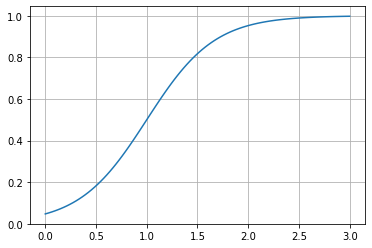

In [5]:
from importlib import reload
import reservoir.reservoir

from reservoir.reservoir import update_reservoir, ridge_regression, train, run
from reservoir.reservoir import init_matrices
from reservoir.reservoir import synaptic_scaling, activation_target_definition, constant_synaptic_scaling
from reservoir.activation_functions import tanh, heaviside, sigmoid

reload(reservoir.reservoir)

# SEED
SEED = 3789

# the activation function choosen for the rest of the experiment

activation_function = lambda x : sigmoid(3*x-3)

plt.plot(np.linspace(0, 3, 100), activation_function(np.linspace(0, 3, 100)))
plt.grid()

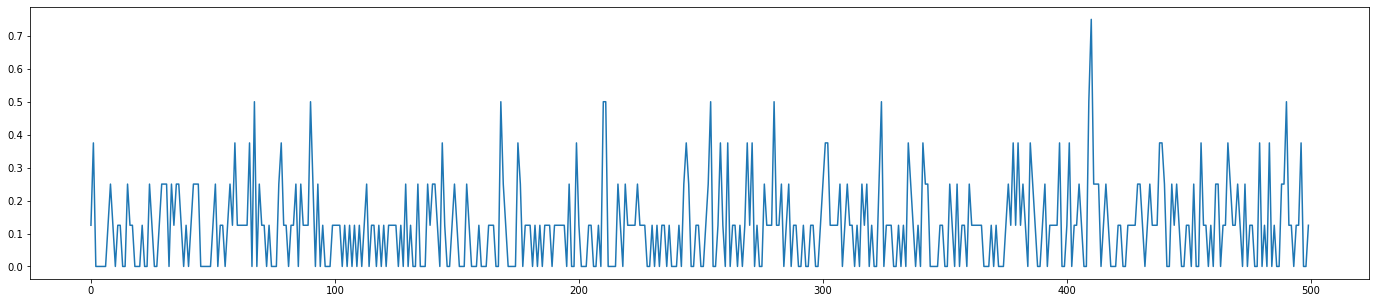

In [6]:
from scipy.stats import poisson

mu = 1
timesteps = 50000

U = poisson.rvs(mu, size=timesteps, random_state = SEED)[np.newaxis].T

# rescale between 0 and 1
U_train1 = (U - U.min()) / (U.max() - U.min())

plt.figure(figsize=(24,5))
plt.plot(range(500), U_train1[:500])
plt.show()

# Activity dependant connexion
https://www.nature.com/articles/s41598-018-22077-3#Fig1

In [38]:
from importlib import reload
import connexion_generation.activity_dependant_connexion
from connexion_generation.activity_dependant_connexion import compute_synaptic_change, add_activity_connexion
from connexion_generation.activity_dependant_connexion import select_pairs_connexion, select_pairs_pruning, change_connexion
reload(connexion_generation.activity_dependant_connexion)

<module 'connexion_generation.activity_dependant_connexion' from '/home/idlab278/Code/structural_plasticity/adsp/connexion_generation/activity_dependant_connexion.py'>

## Simulation

In [39]:
def count_incoming_connexions(W):
    incoming_connexion = W.nonzero()[0]
    incoming_connexion_count = np.zeros(W.shape[0])
    for i in incoming_connexion:
        incoming_connexion_count[i] +=1
    return incoming_connexion_count

In [40]:
# Parameters
n = 50 # number of neurons
SEED = 3789
leaky_rate = 1
input_scaling = 1

spectral_radius = 1.45
input_connectivity =  0.745
connectivity = 0.075

# HPERPARAMETERS
INCREMENT = 20
VALUE = 0.1
bias_scaling = 1


# Initialisation
Win, W, bias =  init_matrices(n, input_connectivity, connectivity, spectral_radius, seed = SEED)
bias = bias*bias_scaling
Win = Win*input_scaling

# last_state
last_state = np.random.uniform(0, 1, n)

### Influence of target and growth parameters

In [59]:
results = {"target_activation_levels" : [] , "growth_parameter": [], "final_connectivity" : [], "convergence_step":[]}

for growth_parameter in np.logspace(-2, -0.1, 6):
    final_connectivity_by_level = []
    for target_activation_levels in np.linspace(0.05, 0.95, 10):
        # Initialisation
        W_with_activity = W.copy()
        U_train3 = U_train1
        state = last_state
        length = len(U_train3)
        step=0
        total_add = 0
        total_prun = 0
        
        # Watched variables
        convergence_step = 0
        add = []
        prun = []
        incoming_connexion_count_history = []
        delta_z_history = []
        state_history =  []
        
        for i in range(INCREMENT):
            state = update_reservoir(W_with_activity, Win, U_train3[i], state, leaky_rate, bias, activation_function)
            state_history.append(state)
        U_train3 = U_train3[INCREMENT:]
        length = len(U_train3)
        
        while total_add + total_prun< 3000 and length > 5000:

            incoming_connexion_count_history.append(count_incoming_connexions(W_with_activity))
            delta_z = compute_synaptic_change(state_history[-INCREMENT:], target_activation_levels, growth_parameter, time_window = INCREMENT)
            
            W_with_activity, nb_new_add, nb_new_prun = add_activity_connexion(W_with_activity, state, delta_z, VALUE)

            for i in range(INCREMENT):
                state = update_reservoir(W_with_activity, Win, U_train3[i], state, leaky_rate, bias, activation_function)
                state_history.append(state)
            U_train3 = U_train3[INCREMENT:]
            length = len(U_train3)
            
            total_add += nb_new_add
            total_prun += nb_new_prun
            add.append(total_add)
            prun.append(total_prun)
            if step > 5 and convergence_step == 0:
                mean_add = (add[-1]-add[-5])/2
                mean_prun = (prun[-1]-prun[-5])/2
                if prun[3] > add[3] and mean_add >= mean_prun: 
                    convergence_step = step
                if prun[3] < add[3] and mean_add <= mean_prun: 
                    convergence_step = step
            step +=1

        results["final_connectivity"].append(W_with_activity.count_nonzero()/n**2)
        results["convergence_step"].append(convergence_step)
        results["target_activation_levels"].append(target_activation_levels)
        results["growth_parameter"].append(growth_parameter)

In [60]:
df = pd.DataFrame.from_dict(results)

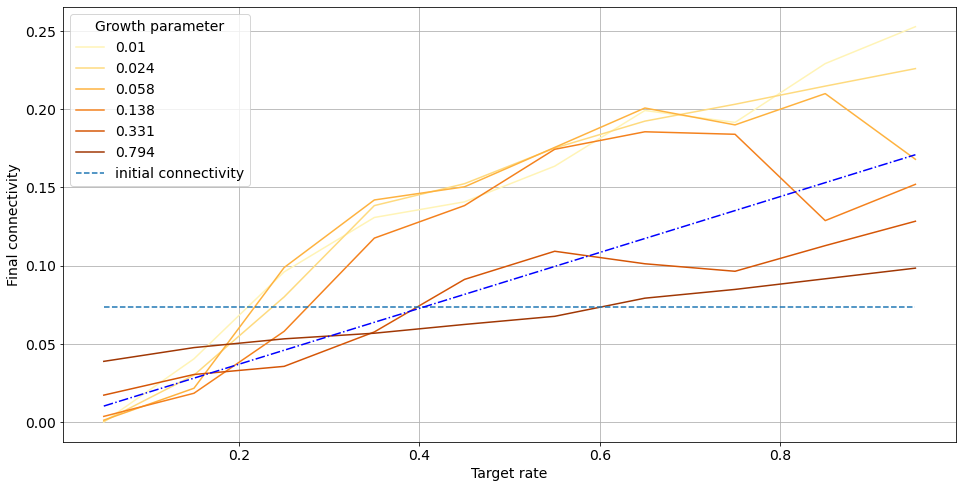

In [61]:
%matplotlib inline
MEDIUM_SIZE = 14
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes

fig, ax = plt.subplots(figsize=(16,8))
color_map = color_palette("YlOrBr", n_colors=6)

i = 0
for key, grp in df.groupby(['growth_parameter']):
    ax.plot(grp['target_activation_levels'], grp['final_connectivity'], label=round(key*1000)/1000, c = color_map[i])
    i += 1
ax.plot(np.linspace(0.05, 0.95, 10), [W.count_nonzero()/n**2]*10, linestyle = "--", label="initial connectivity")

mean_low = df.loc[df["target_activation_levels"]  == 0.05]["final_connectivity"].mean()
mean_high = df.loc[df["target_activation_levels"]  == 0.95]["final_connectivity"].mean()
ax.plot([0.05, 0.95], [mean_low, mean_high],linestyle = "-.", c = "b")

ax.legend( title="Growth parameter")
ax.set_xlabel('Target rate')
ax.set_ylabel('Final connectivity')
ax.grid(True)

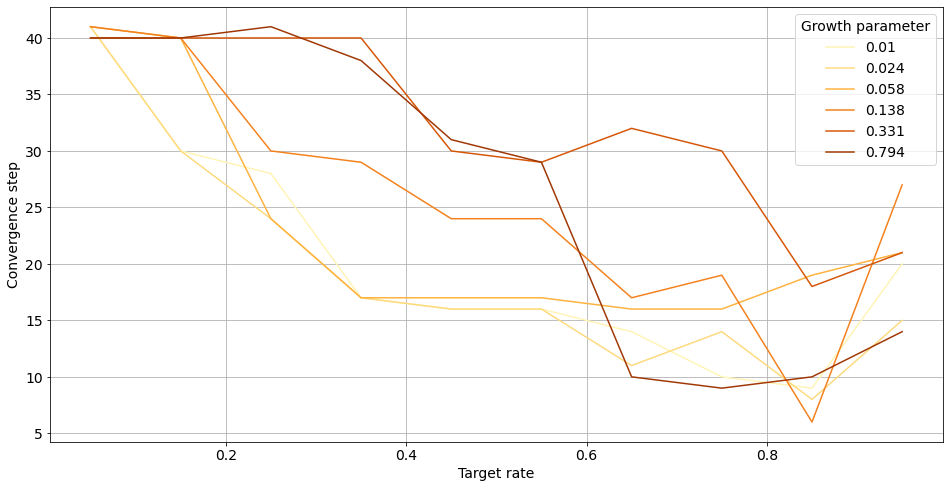

In [62]:
%matplotlib inline
MEDIUM_SIZE = 14
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes

color_map = color_palette("YlOrBr", n_colors=6)

i = 0
fig, ax = plt.subplots(figsize=(16,8))
for key, grp in df.groupby(['growth_parameter']):
    ax.plot(grp['target_activation_levels'], grp['convergence_step'], label=round(key*1000)/1000, c = color_map[i])
    i += 1
    
ax.legend( title="Growth parameter")
ax.set_xlabel('Target rate')
ax.set_ylabel('Convergence step')
ax.grid(True)

TypeError: unsupported operand type(s) for -: 'list' and 'list'

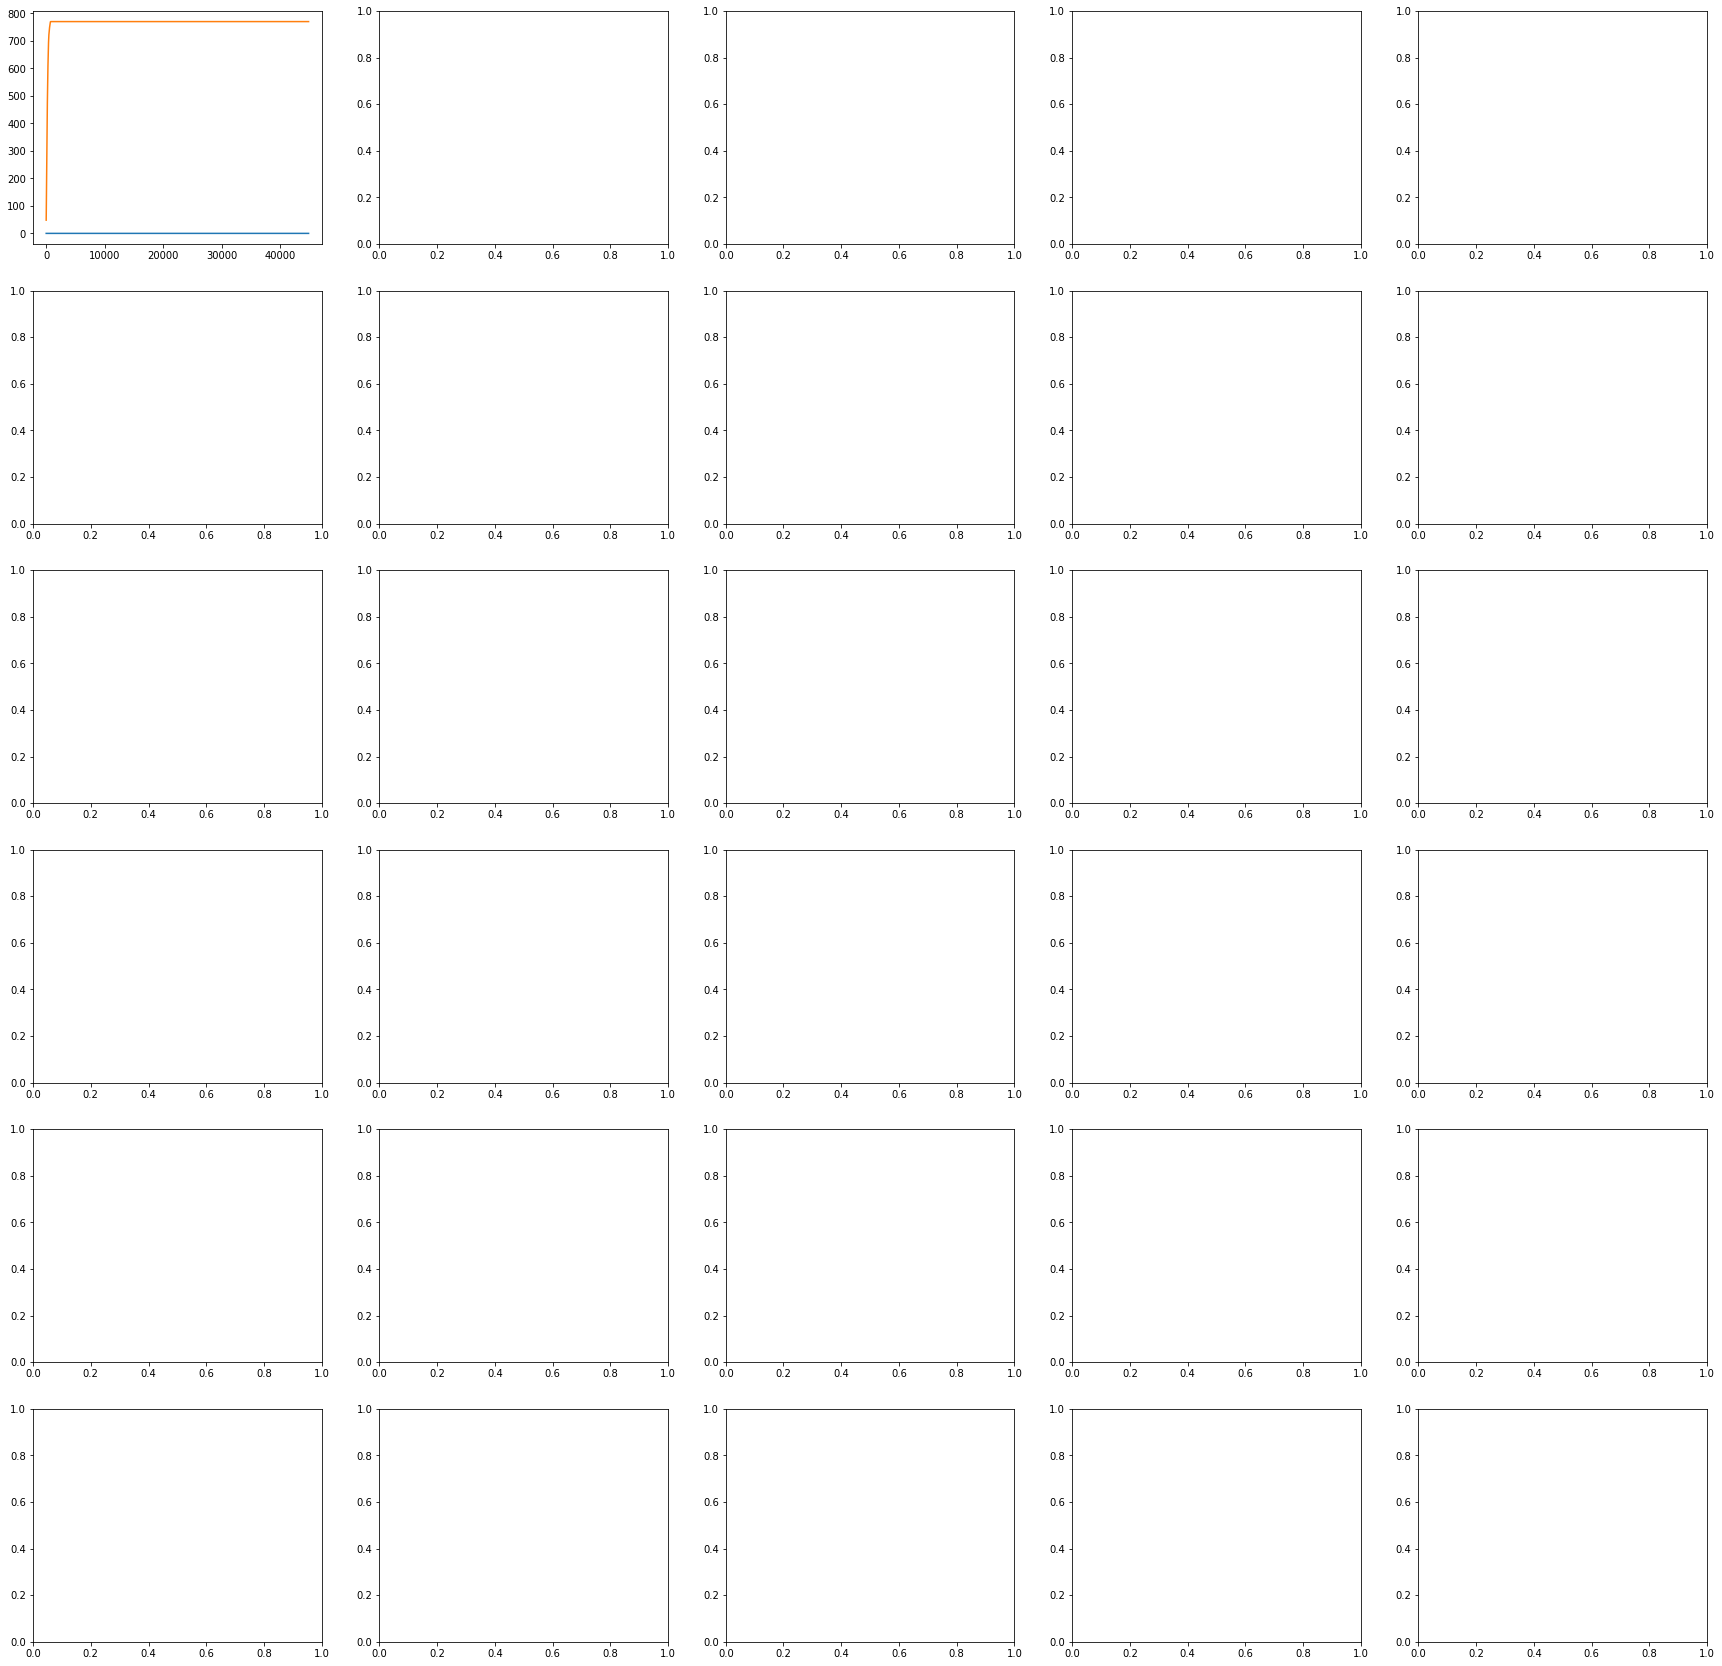

In [63]:
%matplotlib inline
# Parameters
minimum_calcium_concentration = np.ones(n)*0.1

# The parameters you want to see the influence
fig, ax = plt.subplots(6, 5, figsize=(30,30))
k = 0
for growth_parameter in [0.001, 0.01, 0.03, 0.3, 0.5, 0.8]:
    j = 0
    for target_activation_levels in [0.05, 0.1, 0.5, 0.7, 0.95]:

        # Initialisation
        W_with_activity = W.copy()
        U_train3 = U_train1
        state = last_state
        length = len(U_train3)
        step=0
        convergence_step = 0

        total_add = 0
        total_prun = 0
        add = []
        prun = []
        mean_prun = []

        incoming_connexion_count_history = []
        state_history = []
        delta_z_history = []

        for i in range(INCREMENT*5):
            state = update_reservoir(W_with_activity, Win, U_train3[i], state, leaky_rate, bias, activation_function)
            state_history.append(state)
        U_train3 = U_train3[INCREMENT*5:]
        
        while total_add + total_prun < 10000 and length > 5000:

            incoming_connexion_count_history.append(count_incoming_connexions(W_with_activity))
            delta_z = compute_synaptic_change(state_history[-INCREMENT:], target_activation_levels, growth_parameter, time_window = INCREMENT)
            delta_z_history.append(delta_z)

            W_with_activity, nb_new_add, nb_new_prun = add_activity_connexion(W_with_activity, state, delta_z, VALUE)

            for i in range(INCREMENT):
                state = update_reservoir(W_with_activity, Win, U_train3[i], state, leaky_rate, bias, activation_function)
                state_history.append(state)
            U_train3 = U_train3[INCREMENT:]

            length = len(U_train3)
            total_add += nb_new_add
            total_prun += nb_new_prun
            add.append(total_add)
            prun.append(total_prun)
            if step > 5 and convergence_step == 0:
                mean_add = (add[-1]-add[-5])/2
                mean_prun = (prun[-1]-prun[-5])/2
                if prun[3] > add[3] and mean_add >= mean_prun: 
                    convergence_step = step
                if prun[3] < add[3] and mean_add <= mean_prun: 
                    convergence_step = step
            step +=1
        ax[k][j].plot(np.arange(step)*INCREMENT, add, label="total number of added connexion")
        ax[k][j].plot(np.arange(step)*INCREMENT, prun, label="total number of prunned connexion")
        ax[k][j].plot(np.arange(step)*INCREMENT, add-prun, label="difference")
        ax[k][j].plot(np.arange(step)*INCREMENT, [0]*step, linestyle=(0, (1, 10)))
        ax[k][j].title.set_text(f'target :{target_activation_levels} and growth :{growth_parameter} ')
        ax[k][j].legend()
        j+=1    
    k+= 1


### Visualisation of one evolution 

#### first set of parameters

In [ ]:
# Parameters
minimum_calcium_concentration = np.ones(n)*0.1

# The parameters you want to see the influence

growth_parameter = 0.7
target_rate=0.5

# Initialisation
W_with_activity = W.copy()
U_train3 = U_train1
state = last_state
length = len(U_train3)
step=0
convergence_step = 0

total_add = 0
total_prun = 0
add = []
prun = []
mean_prun = []

incoming_connexion_count_history = []
state_history = []
delta_z_history = []

for i in range(INCREMENT*5):
    state = update_reservoir(W_with_activity, Win, U_train3[i], state, leaky_rate, bias, activation_function)
    state_history.append(state)
U_train3 = U_train3[INCREMENT:]

while total_add + total_prun < 5000 and length > 5000:

    incoming_connexion_count_history.append(count_incoming_connexions(W_with_activity))
    delta_z = compute_synaptic_change(state_history[-INCREMENT:], target_rate, growth_parameter, time_window = INCREMENT)
    delta_z_history.append(delta_z)
    W_with_activity, nb_new_add, nb_new_prun = add_activity_connexion(W_with_activity, state, delta_z, VALUE)

    for i in range(INCREMENT):
        state = update_reservoir(W_with_activity, Win, U_train3[i], state, leaky_rate, bias, activation_function)
        state_history.append(state)
    U_train3 = U_train3[INCREMENT:]
    
    length = len(U_train3)
    total_add += nb_new_add
    total_prun += nb_new_prun
    add.append(total_add)
    prun.append(total_prun)
    if step > 5 and convergence_step == 0:
        mean_add = (add[-1]-add[-5])/2
        mean_prun = (prun[-1]-prun[-5])/2
        if prun[3] > add[3] and mean_add >= mean_prun: 
            convergence_step = step
        if prun[3] < add[3] and mean_add <= mean_prun: 
            convergence_step = step
    step +=1

In [ ]:
from math import copysign

plt.figure(figsize=(30,14))
plt.suptitle(f'Dynamics for growth_parameter = {growth_parameter} and target = {target_activation_levels}', fontsize=16)

# NEURON ACTIVITY PLOT 
ax0 = plt.subplot2grid((4, 3), (0, 0), colspan=3, rowspan=2)
random_neurons_indices =  np.sort(np.random.randint(n, size=4)) #Size max is 19 because there is not enough colors
colors = color_palette("tab20")
    # NUMBER_OF_STEP_TO_WATCH 
WATCH_FROM = 0
WATCH_TO = 1000
neurons_evolution = np.array(state_history)[WATCH_FROM:WATCH_TO]
x =range(step*INCREMENT)[WATCH_FROM:WATCH_TO]
j = 0
for i in random_neurons_indices:
    ax0.plot(x, neurons_evolution[: ,i], label=str(i), color=colors[j])
    ax0.text(-3+WATCH_FROM, neurons_evolution[0, i],  str(i), color="black", fontsize=12)
    j += 1
ax0.plot(x, [target_activation_levels]*(WATCH_TO-WATCH_FROM), linestyle = "--", label="initial connectivity")
# plt.legend(fontsize=16, loc="right")


# TOTAL ADDITION AND PRUNING OF CONNEXIONS 
ax1 = plt.subplot2grid((4, 3), (2, 0), colspan=2)
ax1.plot(np.arange(step)*INCREMENT, add, label="total number of added connexion")
ax1.plot(np.arange(step)*INCREMENT, prun, label="total number of prunned connexion")
ax1.legend()

ax3 = plt.subplot2grid((4, 3), (2, 2), rowspan=2)

ax4 = plt.subplot2grid((4, 3), (3, 0))
heatmap(Win.A.reshape(5,10), square=True, cmap=color_palette("vlag", as_cmap=True)
            , annot = incoming_connexion_count_history[-1].reshape(5,10), ax = ax4)
ax4.text(0, 6.5, 'Win and incoming connexion count',fontsize=20)

ax5 = plt.subplot2grid((4, 3), (3, 1))
heatmap(bias.reshape(5,10), square=True, cmap=color_palette("vlag", as_cmap=True)
            , annot = incoming_connexion_count_history[-1].reshape(5,10), ax = ax5)
ax5.text(0, 6.5, 'Bias and incoming connexion count',fontsize=20)

plt.show()

##### Delta and number of connexion evolution

In [50]:
%matplotlib inline
from ipywidgets import interact

max_count = np.amax(incoming_connexion_count_history_2)

def f(i):
    heatmap(incoming_connexion_count_history[i].reshape(5,10), vmax=max_count, cbar=False, cmap=color_palette("YlOrBr", n_colors=int(max_count)))

interactive_plot = interact(f, i=(0, step_2-1))

interactive(children=(IntSlider(value=463, description='i', max=927), Output()), _dom_classes=('widget-interac…

In [51]:
%matplotlib inline
from ipywidgets import interact


def f(i):
    heatmap(delta_z_history[i].reshape(5,10), cbar=False, cmap=color_palette("vlag"))

interactive_plot = interact(f, i=(0, step_2-1))


interactive(children=(IntSlider(value=463, description='i', max=927), Output()), _dom_classes=('widget-interac…

#### Richness

In [52]:
UD, frac = uncoupled_dynamics(W_with_activity, Win, bias, state, U_train1, leaky_rate, temp = 1000,A =0.9)
print("UD", UD, "for", frac)

# Spectral radius
eigen_values, eigen_vectors = sparse.linalg.eigs(W_with_activity, k=10, which="LM", maxiter=W.shape[0] * 20, tol = 0.1)
sr = max(abs(eigen_values))
print("spectral radius", sr)

UD 3 for 0.9257510405200439
spectral radius 0.9148805023755283


In [53]:
eigen_values

array([ 0.9148805 +0.j        ,  0.49504763+0.30374156j,
        0.49504763-0.30374156j,  0.30200057+0.43436037j,
        0.30200057-0.43436037j, -0.05145512+0.53179469j,
       -0.05145512-0.53179469j, -0.62982924+0.j        ,
       -0.51852079+0.18181184j, -0.51852079-0.18181184j])

#### Network analysis 

Papers : 
https://link.springer.com/article/10.1007/s11047-020-09823-1

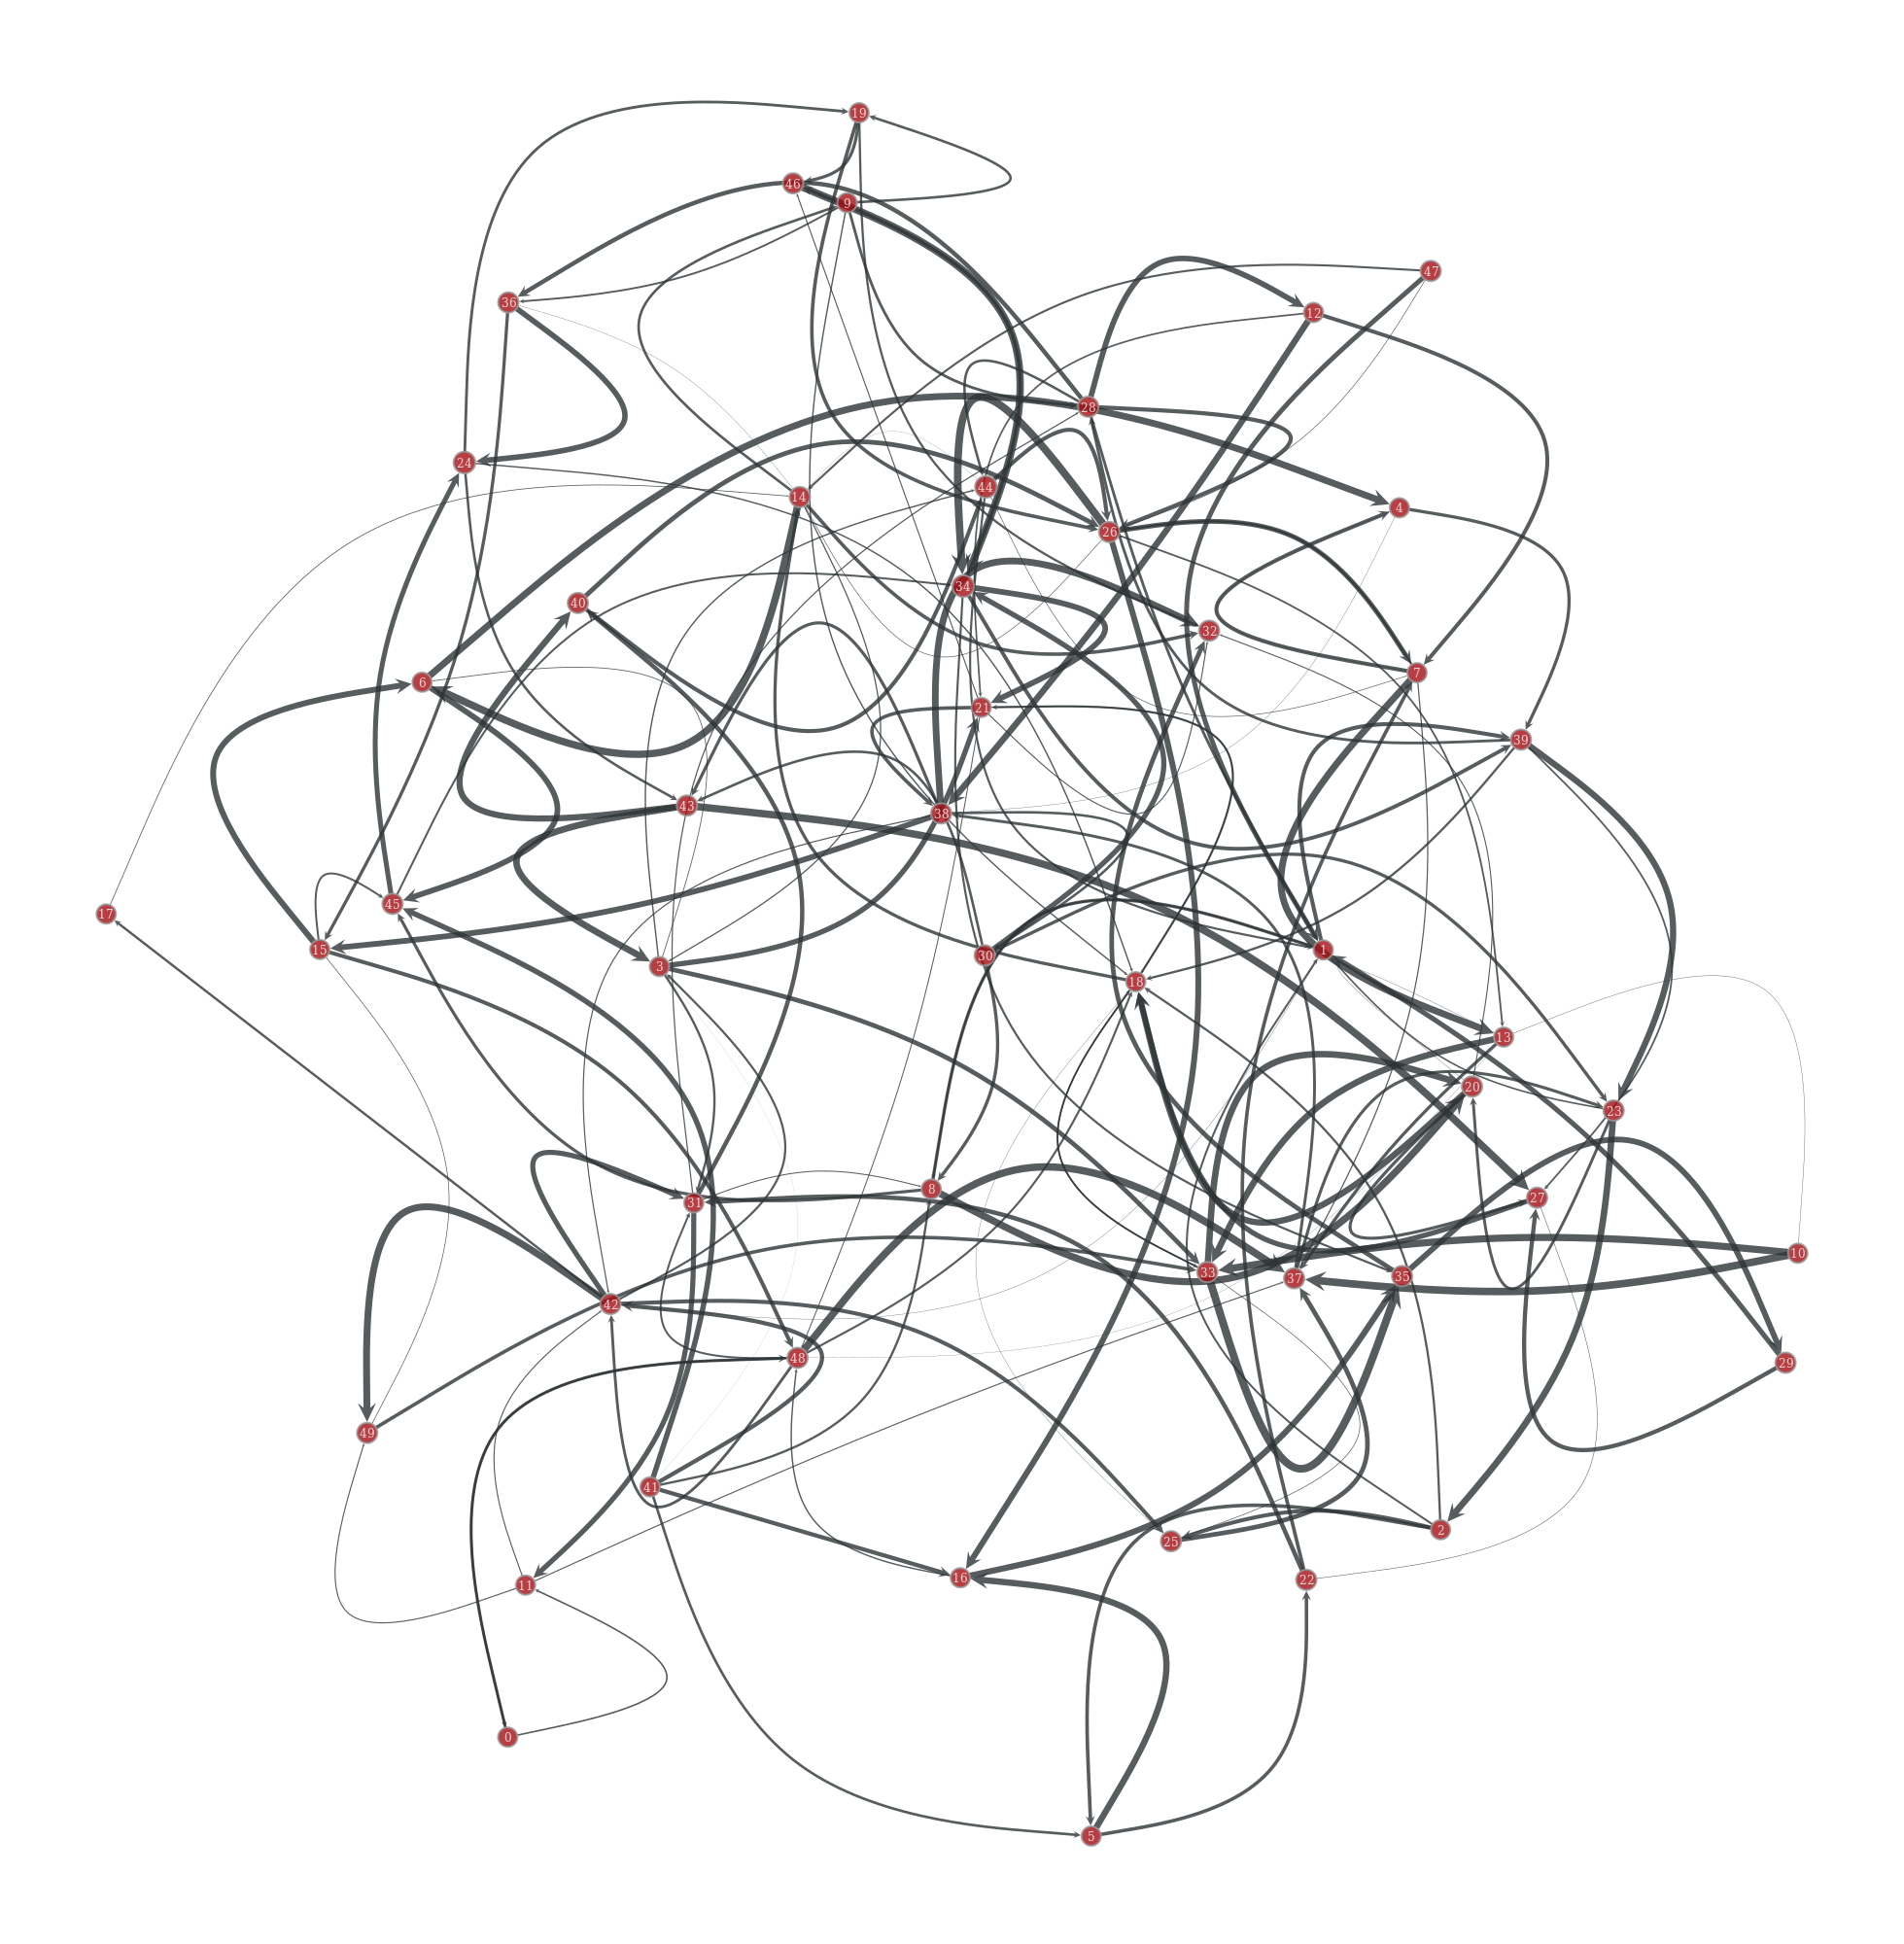

In [54]:
draw_network(W_with_activity)

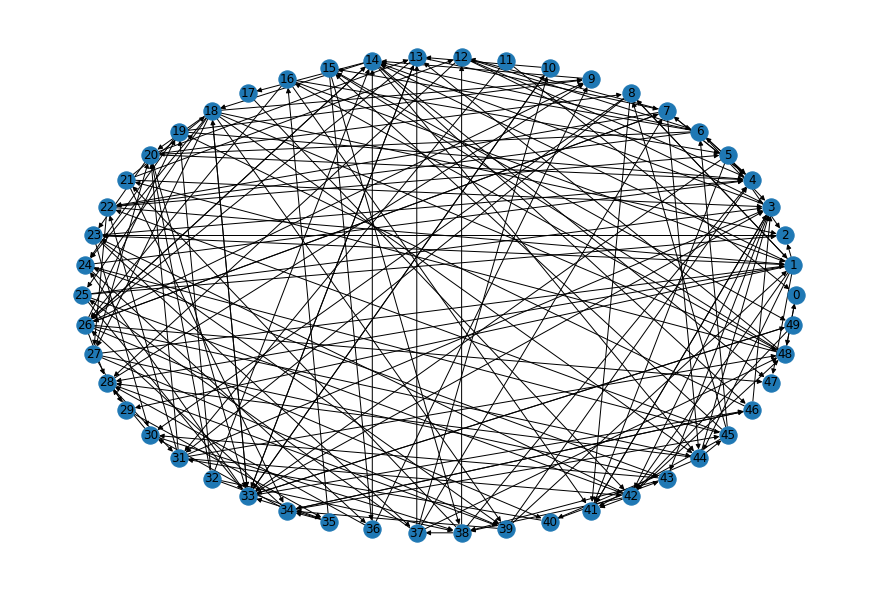

In [55]:
import networkx as nx

G = nx.from_scipy_sparse_array(W.T, create_using=nx.DiGraph)

G_with_activity = nx.from_scipy_sparse_array(W_with_activity.T, create_using=nx.DiGraph)

%matplotlib inline

plt.figure(figsize=(12,8))
nx.draw(G, pos=nx.circular_layout(G), with_labels = True)

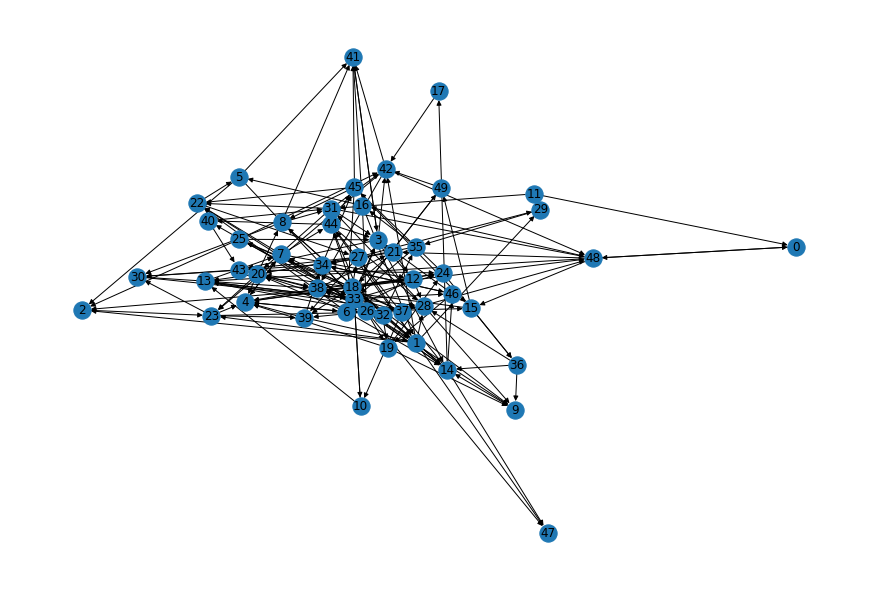

In [56]:
plt.figure(figsize=(12,8))
pos = nx.spring_layout(G, seed=10396953)
nx.draw(G, pos=pos, with_labels = True)

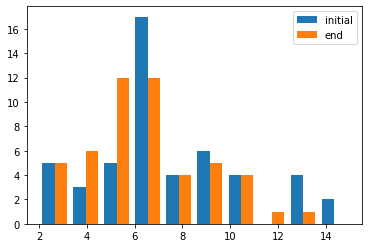

In [57]:
degrees = [val for (node, val) in G.degree()]
degrees_with_activity = [val for (node, val) in G_with_activity.degree()]

d1 = np.array(degrees)
d2 = np.array(degrees_with_activity)

plt.hist([d1, d2], label=['initial', 'end'])
plt.legend(loc='upper right')
plt.show()


In [58]:
# get the local cluster coefficient dataframe
def get_eccentricity_df(graph):
    eccentricity_df = pd.DataFrame(sorted(nx.eccentricity(graph).items(), 
                                 key=lambda item: -item[1]), 
                      columns=["node", "eccentricity"])
    return eccentricity_df



# get sorted accentricty df
eccentricity_df = get_eccentricity_df(G_with_activity)
eccentricity_df["eccentricity"].plot.hist(figsize=(8,5), title="Eccentricity Distribution");



NetworkXError: Found infinite path length because the digraph is not strongly connected

In [ ]:
def get_graph_info(graph):
    print("Number of nodes:", graph.number_of_nodes())
    print("Number of edges:", graph.number_of_edges())

    if type(graph) == nx.classes.digraph.DiGraph:
        print("Connected components:", 
              list(nx.weakly_connected_components(graph)))
    else:
        print("Connected components:", list(nx.connected_components(graph)))
    print("Node degree:", dict(graph.degree()))


    
# get the local cluster coefficient dataframe
def get_local_cluster_coefficient(graph):
    LCC_df = pd.DataFrame(sorted(nx.clustering(graph).items(), 
                                 key=lambda item: -item[1]), 
                      columns=["node", "LCC"])
    return LCC_df

In [ ]:
from networkx.algorithms.community import louvain_partitions
import networkx.algorithms.community as nx_comm

# find communities
girvan_newman_communities = list(louvain_partitions(G))

# function create node color list for less than 7 communities
# when there are more than 6 colors, visualization can be confusing for human
def create_community_node_colors(graph, communities):
    number_of_colors = len(communities[0])
    colors = ["#EF9A9A", "#BA68C8", "#64B5F6", "#81C784",
              "#FFF176", "#BDBDBD"][:number_of_colors]
    node_colors = []
    
    # iterate each node in the graph and find which community it belongs to
    # if the current node is found at a specific community, add color to the 
    # node_colors list
    for node in graph:
        current_community_index = 0
        for community in communities:
            if node in community:
                node_colors.append(colors[current_community_index])
                break
            current_community_index += 1
    return node_colors

def visualize_communities(graph, communities):
    # create visualization
    node_colors = create_community_node_colors(graph, communities)
    modularity = round(nx_comm.modularity(graph, communities), 6)
    title = f"Community Visualization of {len(communities)} communities with modularity of {modularity}"
    pos = nx.spring_layout(graph, 
                           k=0.3, iterations=50,
                           SEED=2)

    plt.figure(1,figsize=(10,6)) 
    nx.draw(graph,
            pos = pos,
            node_size=1000,
            node_color=node_colors,
            with_labels=True,
            font_size = 20,
            font_color='black')
    plt.title(title)
    plt.show() 

visualize_communities(G, girvan_newman_communities[0])

In [ ]:
from math import copysign

plt.figure(figsize=(18, 6))
random_neurons_indices =  np.sort(np.random.randint(n, size=19)) #Size max is 19 because there is not enough colors
# non_zeros_indices = np.flatnonzero(Wout)[:19]
colors = color_palette("tab20")

temp = 400
x =range(temp)
neurons_evolution = np.array(state_history)[:temp]
j = 0
for i in random_neurons_indices:
    plt.plot(x, neurons_evolution[: ,i], label=str(i), color=colors[j])
    plt.plot(0, neurons_evolution[0, i], marker='o', color=colors[j],  alpha=0.5)
    plt.text(-3, neurons_evolution[0, i],  str(i), color="black", fontsize=12)
    j += 1

# plt.plot(np.arange(0, temp), y_pred1[-temp:], label="Training objective", color=colors[-1])

plt.legend(fontsize=16, loc="right")

In [ ]:
show_matrice(W_with_activity)

In [ ]:
show_matrice(W)